In [1]:
import os
import sys
from pathlib import Path

import dxdata
import dxpy
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pyspark
from matplotlib.lines import Line2D

import results

In [2]:
# Flags
GENE = "DRD2"
TRAIT = "QT"

In [3]:
# sc = pyspark.SparkContext()
# spark = pyspark.sql.SparkSession(sc)

In [4]:
# Results files
files = [
    f"file:/mnt/project/data/results/{GENE}/{file}"
    for file in os.listdir(f"/mnt/project/data/results/{GENE}")
]

# Field codings
ukb_coding = pd.read_csv(
    "/opt/notebooks/gogoGPCR/data/misc/Data_Dictionary_Showcase.csv",
    error_bad_lines=False,
    warn_bad_lines=False,
    quotechar='"',
    usecols=["FieldID", "Field"],
)

custom_coding = pd.read_csv(
    "/opt/notebooks/gogoGPCR/data/misc/Data_Dictionary_Custom.csv",
    error_bad_lines=False,
    warn_bad_lines=False,
    quotechar='"',
)

In [5]:
# Load raw DF
df_raw = pd.read_csv(files[0], delimiter=" ", header="infer", comment="#").assign(
    SOURCE=os.path.basename(files[0])
)
df_raw = pd.concat(
    [df_raw]
    + [
        pd.read_csv(fp, delimiter=" ", comment="#").assign(SOURCE=os.path.basename(fp))
        for fp in files[1:]
    ],
    axis=0,
)

In [6]:
# Fix common fields
df = df_raw
df.loc[:, "GENE"] = df.ID.apply(lambda x: x.split(".")[0])
df.loc[:, "MASK"] = df.ALLELE1.apply(lambda x: x.split(".", maxsplit=2)[0])
df.loc[:, "AAF"] = df.ALLELE1.apply(lambda x: x.split(".", maxsplit=1)[-1])
# df.loc[:,"MASK2"] = df.MASK + "." + df.AAF
df.loc[:, "FILE"] = df.SOURCE.apply(
    lambda x: x.split("/")[-1].split("\.")[0].split("_", maxsplit=4)[2:]
)
df.loc[:, "TRAIT"] = df.FILE.apply(lambda x: x[0])
df.loc[:, "PHENO"] = df.FILE.apply(lambda x: x[-1].split(".")[0])
df = df.drop(["ID", "ALLELE0", "ALLELE1", "EXTRA", "SOURCE", "FILE", "TEST"], axis=1)

# Sanity check
df.head()

,CHROM,GENPOS,A1FREQ,N,BETA,SE,CHISQ,LOG10P,GENE,MASK,AAF,TRAIT,PHENO
0,11,113410736,0.000047,149631,0.099278,0.934201,0.011293,0.038404,DRD2,WT,singleton,BT,2463
1,11,113410736,0.004170,149631,0.023026,0.096862,0.056223,0.090140,DRD2,WT,0.01,BT,2463
2,11,113410736,0.000017,149631,0.912393,1.387560,0.432373,0.291726,DRD2,LoF,singleton,BT,2463
3,11,113410736,0.000398,149631,0.581343,0.320565,3.288750,1.156420,DRD2,LoF,0.01,BT,2463
0,11,113410736,0.004202,14159,0.547678,0.211060,7.121170,2.118170,DRD2,WT,0.01,BT,3005


In [7]:
# Filters
bt = df.TRAIT == "BT"
qt = df.TRAIT == "QT"

# Fix Binary Traits
df.loc[bt, "OR"] = np.exp(df.loc[bt, "BETA"])
df.loc[bt, "OR_up"] = np.exp(df.loc[bt, "BETA"] + df.loc[bt, "SE"])
df.loc[bt, "OR_low"] = np.exp(df.loc[bt, "BETA"] - df.loc[bt, "SE"])
df.loc[bt, "OR_up_lim"] = df.loc[bt, "OR_up"] - df.loc[bt, "OR"]
df.loc[bt, "OR_low_lim"] = df.loc[bt, "OR"] - df.loc[bt, "OR_low"]

# Fix Quantitative Traits
df.loc[qt, "BETA_up_lim"] = df.loc[qt, "BETA"] + df.loc[qt, "SE"]
df.loc[qt, "BETA_low_lim"] = df.loc[qt, "BETA"] - df.loc[qt, "SE"]

# Final fixes
df.loc[:, "Phenotype"] = df.PHENO.apply(
    lambda x: results.pheno_search(x, ukb_coding, custom_coding)
    .replace('"', "")
    .strip()
)
df.loc[:, "pval"] = np.power(10, -df["LOG10P"])
df.loc[:, "pval_stars"] = df["pval"].apply(lambda x: results.pval_stars(x))
df.loc[:, "N_pos"] = (2 * df["N"] * df["A1FREQ"]).astype(int)
df.head()

,CHROM,GENPOS,A1FREQ,N,BETA,SE,CHISQ,LOG10P,GENE,MASK,...,OR_up,OR_low,OR_up_lim,OR_low_lim,BETA_up_lim,BETA_low_lim,Phenotype,pval,pval_stars,N_pos
0,11,113410736,0.000047,149631,0.099278,0.934201,0.011293,0.038404,DRD2,WT,...,2.810826,0.433908,1.706454,0.670465,NaN,NaN,Fractured/broken bones in last 5 years,0.915368,,13
1,11,113410736,0.004170,149631,0.023026,0.096862,0.056223,0.090140,DRD2,WT,...,1.127370,0.928824,0.104077,0.094469,NaN,NaN,Fractured/broken bones in last 5 years,0.812568,,1248
2,11,113410736,0.000017,149631,0.912393,1.387560,0.432373,0.291726,DRD2,LoF,...,9.973714,0.621781,7.483439,1.868493,NaN,NaN,Fractured/broken bones in last 5 years,0.510827,,5
3,11,113410736,0.000398,149631,0.581343,0.320565,3.288750,1.156420,DRD2,LoF,...,2.464301,1.297939,0.675862,0.490499,NaN,NaN,Fractured/broken bones in last 5 years,0.069756,,119
0,11,113410736,0.004202,14159,0.547678,0.211060,7.121170,2.118170,DRD2,WT,...,2.135579,1.400204,0.406346,0.329029,NaN,NaN,Fracture resulting from simple fall,0.007618,**,118


In [8]:
phenos_to_remove = [
    "Severe obesity",
    "Date E66 first reported (obesity)",
    "Date I10 first reported (essential (primary) hypertension)",
    "Myocardial disease incl. angina pectoris",
    "Pulse rate, automated reading",
    "Heart attack diagnosed by doctor",
    "Angina diagnosed by doctor",
    "Fracture resulting from simple fall",
    "Stroke diagnosed by doctor",
    "Cholesterol medication",
]

In [9]:
plt_df = (
    df.loc[(df.GENE == GENE)]
    .sort_values(by=["Phenotype", "AAF"], ascending=[True, False])
    .groupby(["Phenotype", "MASK"])
    .first()
    .reset_index()
)


plt_df = plt_df.loc[~plt_df.Phenotype.astype(str).isin(phenos_to_remove), :]

effect = {"BT": "OR", "QT": "BETA"}[TRAIT]

group_by_mean = (
    pd.DataFrame({"mean": plt_df.groupby(["Phenotype"]).agg("mean")[effect]})
    .sort_values(by="mean", ascending=False)
    .reset_index()
)

sorter = group_by_mean.Phenotype.tolist()

plt_df.loc[:, "Phenotype"] = plt_df.loc[:, "Phenotype"].astype("category")
plt_df.loc[:, "Phenotypes"] = plt_df.loc[:, "Phenotype"].cat.set_categories(sorter)

plt_df = plt_df.sort_values(
    by=["Phenotype", "MASK"], ascending=[True, False]
).reset_index(drop=True)

phenotypes = plt_df.Phenotype.unique()

print(len(plt_df))
plt_df.head()

43


,Phenotype,MASK,CHROM,GENPOS,A1FREQ,N,BETA,SE,CHISQ,LOG10P,...,OR_up,OR_low,OR_up_lim,OR_low_lim,BETA_up_lim,BETA_low_lim,pval,pval_stars,N_pos,Phenotypes
0,Arms BMD (bone mineral density),WT,11,113410736,0.004035,16978,-0.096613,0.078164,1.527770,0.664647,...,NaN,NaN,NaN,NaN,-0.018449,-0.174777,0.216448,,136,Arms BMD (bone mineral density)
1,Arms BMD (bone mineral density),LoF,11,113410736,0.000353,16978,-0.235126,0.263140,0.798409,0.429960,...,NaN,NaN,NaN,NaN,0.028014,-0.498266,0.371569,,12,Arms BMD (bone mineral density)
2,Blood pressure medication,WT,11,113410736,0.000047,149438,0.199445,0.718475,0.077059,0.107169,...,2.504076,0.595098,1.283351,0.625628,NaN,NaN,0.781324,,14,Blood pressure medication
3,Blood pressure medication,LoF,11,113410736,0.000017,149438,-2.184280,1.210430,3.256410,1.147860,...,0.377626,0.033550,0.265068,0.079008,NaN,NaN,0.071144,,4,Blood pressure medication
4,Body fat percentage,WT,11,113410736,0.000045,143970,-0.000620,0.198989,0.000010,0.001080,...,NaN,NaN,NaN,NaN,0.198369,-0.199609,0.997516,,13,Body fat percentage


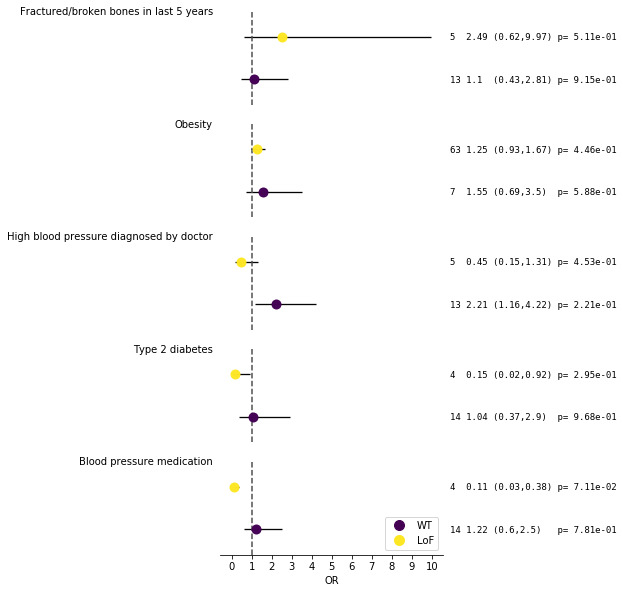

In [14]:
def plot_BT(
    df, width=4, height=12, phenotypes=None, masks=None, lw=1.3, ms=10, fudge=0.6
):

    df = df.loc[df.TRAIT == "BT", :]

    df.loc[:, "CI"] = +(
        "("
        + df.loc[:, "OR_low"].round(2).astype(str)
        + ","
        + df.loc[:, "OR_up"].round(2).astype(str)
        + ")"
    )

    just = df.applymap(lambda x: len(str(x)) + 1).max()

    df.loc[:, "label"] = (
        df.loc[:, "N_pos"].astype(str).str.ljust(just["N_pos"])
        + df.loc[:, "OR"].round(2).astype(str).str.ljust(5)
        + df.loc[:, "CI"].str.ljust(just["CI"])
        + "p= "
        + df.loc[:, "pval"].apply(lambda p: f"{p:.2e}").str.ljust(4)
    )

    if phenotypes is None:
        phenotypes = df.Phenotype.unique()

    num_pheno = len(phenotypes)

    height = 2 * num_pheno

    masks = df.MASK.unique()
    colors = plt.cm.viridis(np.linspace(0, 1, len(masks)))

    fig, axes = plt.subplots(nrows=num_pheno, sharex=True, figsize=(width, height))
    legend_elements = [
        Line2D([0], [0], color=color, marker="o", ms=ms, lw=0, label=mask)
        for color, mask in zip(colors, masks)
    ]

    for i, ax in enumerate(axes):

        temp = df.loc[df.Phenotype.eq(phenotypes[i]), :]
        temp = temp.loc[df.MASK.isin(masks)]

        for mask, color in zip(
            masks,
            colors,
        ):
            temp1 = temp.loc[temp.MASK == mask, :]
            xerr = [temp1["OR_low_lim"].values, temp1["OR_up_lim"].values]

            ax.errorbar(
                temp1["OR"],
                temp1.index,
                alpha=0.99,
                xerr=xerr,
                fmt="o",
                c=color,
                ecolor="black",
                ms=ms,
                mew=0.0,
                mec="black",
                elinewidth=lw,
            )

        ax0 = ax.twinx()
        ax0.yaxis.tick_left()
        ax.yaxis.tick_right()
        ax.set_ylim(temp.index[0] - fudge, temp.index[1] + fudge)
        ax.set_yticks([temp.index[0], temp.index[1]])
        ax.set_xlim(0 - fudge, df.OR_up.max() + fudge)
        ax.set_xticks(np.arange(0, int(df.OR_up.max()) + 2, 1))

        ax.set_yticklabels(temp.label, fontsize=9, fontdict={"family": "monospace"})

        ax.tick_params(right=False)
        ax.spines["top"].set_alpha(0)
        ax.spines["left"].set_alpha(0)
        ax.spines["right"].set_alpha(0)
        ax.spines["bottom"].set_alpha(0)

        ax0.tick_params(right=False)
        ax0.tick_params(left=False)
        ax0.spines["top"].set_alpha(0)
        ax0.spines["left"].set_alpha(0)
        ax0.spines["right"].set_alpha(0)

        ax0.grid(False)

        # only show every 3rd yticklabel
        labels = [
            l if i % len(masks) == 0 else "" for i, l in enumerate(temp.Phenotype)
        ]
        ax0.set(yticks=temp.index, yticklabels=labels[::-1])

        ax.axvline(x=1, linestyle="--", color="#4f4f4f")

        ax0.spines["top"].set_alpha(0)
        ax0.spines["left"].set_alpha(0)
        ax0.spines["right"].set_alpha(0)

        if i != len(phenotypes) - 1:
            ax0.spines["bottom"].set_alpha(0)
            ax.tick_params(bottom=False)

        if i == len(phenotypes) - 1:
            ax.set_xlabel("OR")
            ax.tick_params(bottom=True)
            ax.legend(handles=legend_elements, loc="lower right")

    return temp


temp = plot_BT(plt_df)

In [11]:
def make_plt_df(
    df: pd.DataFrame,
    phenos_to_remove,
    trait=TRAIT,
    gene=GENE,
) -> pd.DataFrame:

    plt_df = (
        df.loc[(df.GENE == GENE)]
        .sort_values(by=["Phenotype", "AAF"], ascending=[True, False])
        .groupby(["Phenotype", "MASK"])
        .first()
        .reset_index()
    )

    plt_df = plt_df.loc[~plt_df.Phenotype.isin(phenos_to_remove), :]

    effect = {"BT": "OR", "QT": "BETA"}[TRAIT]

    group_by_mean = pd.DataFrame(
        {"mean": plt_df.groupby(["Phenotype"]).agg("mean")[effect]}
    ).reset_index()

    group_by_mean = group_by_mean.sort_values(by="mean", ascending=False).reset_index()

    sorter = list(group_by_mean["Phenotype"])

    plt_df.loc[:, "Phenotype"] = plt_df.loc[:, "Phenotype"].astype("category")
    plt_df.loc[:, "Phenotype"].cat.set_categories(sorter, inplace=True)

    plt_df = plt_df.sort_values(
        by=["Phenotype", "MASK"], ascending=[True, False]
    ).reset_index(drop=True)

    phenotypes = plt_df.Phenotype.unique()

    return plt_df


plt_df = make_plt_df(df, phenos_to_remove=phenos_to_remove)
plt_df.head()

,Phenotype,MASK,CHROM,GENPOS,A1FREQ,N,BETA,SE,CHISQ,LOG10P,...,OR,OR_up,OR_low,OR_up_lim,OR_low_lim,BETA_up_lim,BETA_low_lim,pval,pval_stars,N_pos
0,Diastolic blood pressure,WT,11,113410736,0.000048,146503,0.441296,0.255072,2.993190,1.077710,...,NaN,NaN,NaN,NaN,NaN,0.696368,0.186224,0.083616,,14
1,Diastolic blood pressure,LoF,11,113410736,0.000017,146503,0.730394,0.426809,2.928520,1.060350,...,NaN,NaN,NaN,NaN,NaN,1.157203,0.303585,0.087026,,5
2,Fractured/broken bones in last 5 years,WT,11,113410736,0.000047,149631,0.099278,0.934201,0.011293,0.038404,...,1.104373,2.810826,0.433908,1.706454,0.670465,NaN,NaN,0.915368,,13
3,Fractured/broken bones in last 5 years,LoF,11,113410736,0.000017,149631,0.912393,1.387560,0.432373,0.291726,...,2.490275,9.973714,0.621781,7.483439,1.868493,NaN,NaN,0.510827,,5
4,Obesity,WT,11,113410736,0.000041,85706,0.440727,0.813380,0.293597,0.230678,...,1.553836,3.504707,0.688904,1.950871,0.864932,NaN,NaN,0.587925,,7


In [ ]:
for ax in range(0, len(phenotypes)):
    temp = plt_df.loc[plt_df.Phenotype.eq(phenotypes[ax]), :]
    temp = temp.loc[plt_df.MASK.isin(masks)]

    temps = [temp[temp.MASK == mask] for mask in masks]

    if TRAIT == "BT":
        xerrs = [[temp["OR_se_l"].values, temp["OR_se_u"].values] for temp in temps]

    elif TRAIT == "QT":
        xerrs = [temp["OR_se"] for temp in temps]

    axes[ax].errorbar(
        temps[0]["OR"],
        temps[0].index,
        alpha=0.99,
        xerr=xerrs[0],
        fmt="o",
        c="tab:grey",
        ecolor="black",
        ms=ms,
        mew=0.0,
        mec="black",
        elinewidth=lw,
    )
    axes[ax].errorbar(
        temps[1]["OR"],
        temps[1].index,
        alpha=0.99,
        xerr=xerrs[1],
        fmt="o",
        c="tab:purple",
        ecolor="black",
        ms=ms,
        mew=0.0,
        mec="black",
        elinewidth=lw,
    )
    # axes[ax].errorbar(
    #    temps[2]["OR"],
    #    temps[2].index,
    #    alpha=0.99,
    #    xerr=xerrs[2],
    #    fmt="o",
    #    c="tab:orange",
    #    ecolor="black",
    #    ms=ms,
    #    mew=0.0,
    #    mec="black",
    #    elinewidth=lw,
    # )

    ax0 = axes[ax].twinx()
    ax0.set_ylim([0.25, 3.25])
    ax0.set_yticks(
        [
            1,
            2,
        ]
    )

    y2labels = (
        temp.N_pos.astype(str)
        #    + temp.or_e.astype(str).str.ljust(5).values
        #    + ["("]
        #    + temp.lower_e.values
        #    + [","]
        #    + temp.upper_e.values
        + ["   p = "]
        + temp.pval_e.values
    )

    ax0.set_yticklabels(y2labels, fontsize=9, fontdict={"family": "monospace"})
    ax0.tick_params(right=False)
    ax0.spines["top"].set_alpha(0)
    ax0.spines["left"].set_alpha(0)
    ax0.spines["right"].set_alpha(0)
    ax0.spines["bottom"].set_alpha(0)
    ax0.grid(False)
    # axes[ax].invert_xaxis()
    # only show every 3rd yticklabel
    labels = [l if i % 3 == 0 else "" for i, l in enumerate(temp.Phenotype)]
    axes[ax].set(yticks=temp.index, yticklabels=labels[::-1])

    # axes[ax].axvline(x=0, linestyle="--", color="#4f4f4f")
    axes[ax].tick_params(left=False)

    if TRAIT == "BT":
        axes[ax].set_xlim([-0.2, 5.2])
        axes[ax].axvline(x=1, linestyle=":", color="#4f4f4f")
    elif TRAIT == "QT":
        axes[ax].set_xlim([-0.22, 0.82])
        axes[ax].axvline(x=0, linestyle=":", color="#4f4f4f")

    axes[ax].spines["top"].set_alpha(0)
    axes[ax].spines["left"].set_alpha(0)
    axes[ax].spines["right"].set_alpha(0)
    if ax != len(phenotypes) - 1:
        axes[ax].spines["bottom"].set_alpha(0)
        axes[ax].tick_params(bottom=False)

    if ax == len(phenotypes) - 1:
        axes[ax].set_xlabel(xlab)
        # ax0.legend(handles = legend_elements, loc = "lower right")
#
# axes[len(phenotypes) - 1].set_xticks([0,1,2,3,4,5,6,7,])
for ax in axes.flat:
    ax.margins(0.3)

plt.subplots_adjust(right=1)
# fig.suptitle(title)

# plt.savefig(f"/opt/notebooks/gogoGPCR/tmp/{GENE}_{TRAIT}_new.svg", dpi = 600, bbox_inches="tight", format = "svg")
plt.show()

In [ ]:
###
### ALL THE OLD SHIT
###
# -*- coding: utf-8 -*-
# ---
# jupyter:
#   jupytext:
#     formats: ipynb,py:percent
#     text_representation:
#       extension: .py
#       format_name: percent
#       format_version: '1.3'
#       jupytext_version: 1.13.1
#   kernelspec:
#     display_name: Python 3
#     language: python
#     name: python3
# ---

In [ ]:
# !pip install -U matplotlib

In [ ]:
import os

import dxdata
import dxpy
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pyspark
import tomli
from matplotlib.lines import Line2D

In [ ]:
with open("../config.toml") as f:
    conf = tomli.load(f)

GENE = conf["GENE"]
# REFERENCE_GENOME = conf["REFERENCE_GENOME"]
# LOG_FILE = Path(conf["IMPORT"]["LOG_DIR"], f"{GENE}_results.log").resolve().__str__()

In [ ]:
# Spark and Hail
sc = pyspark.SparkContext()
spark = pyspark.sql.SparkSession(sc)

# hl.init(sc=sc, default_reference=REFERENCE_GENOME, log=LOG_FILE)

In [ ]:
def pval(x):
    if x < 0.0001:
        return "****"
    if x < 0.001:
        return "***"
    if x < 0.01:
        return "**"
    if x < 0.05:
        return "*"
    if x > 0.05:
        return ""


def pheno_search(x):
    try:
        return ukb_coding[ukb_coding.FieldID == int(x)].Field.values[0]
    except:
        # coding from https://biobank.ndph.ox.ac.uk/showcase/coding.cgi?id=100605
        if x == "6150_1":
            return "Heart attack diagnosed by doctor"
        elif x == "6150_2":
            return "Angina diagnosed by doctor"
        elif x == "6150_3":
            return "Stroke diagnosed by doctor"
        elif x == "6150_4":
            return "High blood pressure diagnosed by doctor"
        elif x == "myo":
            return "myocardial disease incl. angina pectoris"
        elif x == "3005":
            return "Fracture resulting from simple fall"
        else:
            return x


def fix_df(df, TRAIT):
    if TRAIT == "BT":
        df["OR"] = np.exp(df.BETA)
        df["OR_upper"] = np.exp(df.BETA + df.SE)
        df["OR_lower"] = np.exp(df.BETA - df.SE)
        df["OR_se"] = df["OR_upper"] - df["OR_lower"]
        df["OR_se_l"] = df["OR"] - df["OR_lower"]
        df["OR_se_u"] = df["OR_upper"] - df["OR"]
    elif TRAIT == "QT":
        df.loc[:, "OR"] = df.BETA
        df.loc[:, "OR_se"] = df.SE

    df.loc[:, "Phenotype"] = df.PHENO.apply(lambda x: pheno_search(x))
    df.loc[:, "pval"] = np.power(10, -df["LOG10P"])
    df.loc[:, "pval_e"] = df.pval.apply(lambda x: f"{x:.2f}")
    df.loc[:, "pval_stars"] = df["pval"].apply(lambda x: pval(x))
    df.loc[:, "N_pos"] = (2 * df["N"] * df["A1FREQ"]).astype(int)

    return df

In [ ]:
files = [
    f"file:/mnt/project/data/results/{GENE}/{file}"
    for file in os.listdir(f"/mnt/project/data/results/{GENE}")
]

ukb_coding = pd.read_csv(
    "/opt/notebooks/gogoGPCR/data/misc/Data_Dictionary_Showcase.csv",
    error_bad_lines=False,
    warn_bad_lines=False,
    quotechar='"',
)

custom_coding

In [ ]:
recode = {
    "systolic": "Systolic blood pressure",
    "diastolic": "Diastolic blood pressure",
    "diabetes": "Type 2 diabetes",
    "obesity": "Obesity",
    "blood_pressure_med": "Blood pressure medication",
    "cholesterol_med": "Cholesterol medication",
}

df = pd.read_csv(files[0], delimiter=" ", header="infer", comment="#").assign(
    SOURCE=os.path.basename(files[0])
)
df = pd.concat(
    [df]
    + [
        pd.read_csv(fp, delimiter=" ", comment="#").assign(SOURCE=os.path.basename(fp))
        for fp in files[1:]
    ],
    axis=0,
)

df.loc[:, "GENE"] = df.ID.apply(lambda x: x.split(".")[0])
df.loc[:, "MASK"] = df.ALLELE1.apply(lambda x: x.split(".", maxsplit=2)[0])
df.loc[:, "AAF"] = df.ALLELE1.apply(lambda x: x.split(".", maxsplit=1)[-1])
df.loc[:, "FILE"] = df.SOURCE.apply(
    lambda x: x.split("/")[-1].split("\.")[0].split("_", maxsplit=4)[2:]
)
df.loc[:, "TRAIT"] = df.FILE.apply(lambda x: x[0])
df.loc[:, "PHENO"] = df.FILE.apply(lambda x: x[-1].split(".")[0])
df = df.drop(["ID", "ALLELE0", "ALLELE1", "EXTRA", "SOURCE", "FILE", "TEST"], axis=1)
df.loc[:, "PHENO"] = df.loc[:, "PHENO"].apply(lambda x: recode.get(x, x))
df = df.loc[df["AAF"] != "singleton", :]
df.head()

In [ ]:
# Set trait specific
TRAIT = "QT"

titles = {
    "BT": "Binary Traits",
    "QT": "Quantitative Traits",
}
title = titles[TRAIT]

xlabs = {"BT": "OR", "QT": "β"}
xlab = xlabs[TRAIT]

masks = df.MASK.unique()

# masks = [unique_masks[0], unique_masks[3], unique_masks[1]]

interesting_traits = {
    "QT": [
        "Diastolic blood pressure",
        "Systolic blood pressure",
        "Body mass index (BMI)",
        "Body fat percentage",
    ],
    "BT": [
        "Type 2 diabetes",
        "Obesity",
    ],
}
interesting = interesting_traits[TRAIT]

In [ ]:
# Plotting options

lw = 1.3
ms = 10
height = 2 * len(interesting)

legend_elements = [
    Line2D([0], [0], color="tab:grey", marker="o", ms=ms, lw=0, label="WT-like"),
    Line2D(
        [0], [0], color="tab:orange", marker="o", ms=ms, lw=0, label="cAMP LOF only"
    ),
    Line2D([0], [0], color="tab:purple", marker="o", ms=ms, lw=0, label="Both LOF"),
]

In [ ]:
df2 = df.loc[df.TRAIT.eq(TRAIT), :]
df2 = fix_df(df2, TRAIT=TRAIT)
df2 = df2.loc[df2.Phenotype.isin(interesting)]
df2

In [ ]:
plt_df = (
    df2.loc[(df2.GENE == GENE)]
    .sort_values(by=["Phenotype", "AAF"], ascending=[True, False])
    .groupby(["Phenotype", "MASK"])
    .first()
    .reset_index()
)

plt_df = plt_df.loc[
    ~plt_df.Phenotype.isin(
        [
            "sev_obesity",
            "Date E66 first reported (obesity)",
            "Date I10 first reported (essential (primary) hypertension)",
            "myocardial disease incl. angina pectoris",
            "Pulse rate, automated reading",
            "Heart attack diagnosed by doctor",
            "Angina diagnosed by doctor",
            "Fracture resulting from simple fall",
            "Stroke diagnosed by doctor",
        ]
    )
]

group_by_mean = pd.DataFrame(
    {"mean": plt_df.groupby(["Phenotype"]).agg("mean")["OR"]}
).reset_index()

group_by_mean = group_by_mean.sort_values(by="mean", ascending=False).reset_index()

sorter = list(group_by_mean["Phenotype"])

plt_df.loc[:, "Phenotype"] = plt_df.loc[:, "Phenotype"].astype("category")
plt_df.loc[:, "Phenotype"].cat.set_categories(sorter, inplace=True)

plt_df = plt_df.sort_values(
    by=["Phenotype", "MASK"], ascending=[True, False]
).reset_index(drop=True)

phenotypes = plt_df.Phenotype.unique()

fig, axes = plt.subplots(nrows=len(phenotypes), sharex=True, figsize=(4, height))

for ax in range(0, len(phenotypes)):
    temp = plt_df.loc[plt_df.Phenotype.eq(phenotypes[ax]), :]
    temp = temp.loc[plt_df.MASK.isin(masks)]

    temps = [temp[temp.MASK == mask] for mask in masks]

    if TRAIT == "BT":
        xerrs = [[temp["OR_se_l"].values, temp["OR_se_u"].values] for temp in temps]

    elif TRAIT == "QT":
        xerrs = [temp["OR_se"] for temp in temps]

    axes[ax].errorbar(
        temps[0]["OR"],
        temps[0].index,
        alpha=0.99,
        xerr=xerrs[0],
        fmt="o",
        c="tab:grey",
        ecolor="black",
        ms=ms,
        mew=0.0,
        mec="black",
        elinewidth=lw,
    )
    axes[ax].errorbar(
        temps[1]["OR"],
        temps[1].index,
        alpha=0.99,
        xerr=xerrs[1],
        fmt="o",
        c="tab:purple",
        ecolor="black",
        ms=ms,
        mew=0.0,
        mec="black",
        elinewidth=lw,
    )
    # axes[ax].errorbar(
    #    temps[2]["OR"],
    #    temps[2].index,
    #    alpha=0.99,
    #    xerr=xerrs[2],
    #    fmt="o",
    #    c="tab:orange",
    #    ecolor="black",
    #    ms=ms,
    #    mew=0.0,
    #    mec="black",
    #    elinewidth=lw,
    # )

    ax0 = axes[ax].twinx()
    ax0.set_ylim([0.25, 3.25])
    ax0.set_yticks(
        [
            1,
            2,
        ]
    )

    y2labels = (
        temp.N_pos.astype(str)
        #    + temp.or_e.astype(str).str.ljust(5).values
        #    + ["("]
        #    + temp.lower_e.values
        #    + [","]
        #    + temp.upper_e.values
        + ["   p = "]
        + temp.pval_e.values
    )

    ax0.set_yticklabels(y2labels, fontsize=9, fontdict={"family": "monospace"})
    ax0.tick_params(right=False)
    ax0.spines["top"].set_alpha(0)
    ax0.spines["left"].set_alpha(0)
    ax0.spines["right"].set_alpha(0)
    ax0.spines["bottom"].set_alpha(0)
    ax0.grid(False)
    # axes[ax].invert_xaxis()
    # only show every 3rd yticklabel
    labels = [l if i % 3 == 0 else "" for i, l in enumerate(temp.Phenotype)]
    axes[ax].set(yticks=temp.index, yticklabels=labels[::-1])

    # axes[ax].axvline(x=0, linestyle="--", color="#4f4f4f")
    axes[ax].tick_params(left=False)

    if TRAIT == "BT":
        axes[ax].set_xlim([-0.2, 5.2])
        axes[ax].axvline(x=1, linestyle=":", color="#4f4f4f")
    elif TRAIT == "QT":
        axes[ax].set_xlim([-0.22, 0.82])
        axes[ax].axvline(x=0, linestyle=":", color="#4f4f4f")

    axes[ax].spines["top"].set_alpha(0)
    axes[ax].spines["left"].set_alpha(0)
    axes[ax].spines["right"].set_alpha(0)
    if ax != len(phenotypes) - 1:
        axes[ax].spines["bottom"].set_alpha(0)
        axes[ax].tick_params(bottom=False)

    if ax == len(phenotypes) - 1:
        axes[ax].set_xlabel(xlab)
        # ax0.legend(handles = legend_elements, loc = "lower right")
#
# axes[len(phenotypes) - 1].set_xticks([0,1,2,3,4,5,6,7,])
for ax in axes.flat:
    ax.margins(0.3)

plt.subplots_adjust(right=1)
# fig.suptitle(title)

# plt.savefig(f"/opt/notebooks/gogoGPCR/tmp/{GENE}_{TRAIT}_new.svg", dpi = 600, bbox_inches="tight", format = "svg")
plt.show()

In [ ]:
plt_df["N_pos"]

In [ ]:
df["N_alleles"] = df["N"] * df["A1FREQ"] * 2
df

In [1]:
pheno_search